# Testing Notebook

### Imports

In [53]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy import interpolate
import time
from data_files import file_dict, runs_dict
from testing_class import testing
from range_estimator import range_est

### File Summary

In [54]:

batt_cap = 58   # kWh; useable energy

file_summary = pd.DataFrame({
    'Run_ID': [],
    'Time (min)': [],
    'Max Speed (kts)': [],
    'Avg Speed (kts)': [],
    'Energy Expended (kWh)': [],
    'Distance Traveled (nm)': [],
    'Average Consumption (kWh/nm)': []
})

for run in runs_dict.keys():
    runs_dict[run]['Pack Voltage 1 V'] = runs_dict[run]['Pack Voltage 1 V']*10
    
    time_elapsed = runs_dict[run]['Time'].iloc[-1] - runs_dict[run]['Time'].iloc[0]
    speed_max = runs_dict[run]['Speed m/s'].max()*1.944
    speed_avg = runs_dict[run]['Speed m/s'].mean()*1.944
    battery_expended = runs_dict[run]['SOC 1 %'].iloc[0] - runs_dict[run]['SOC 1 %'].iloc[-1]
    energy_expended = battery_expended*batt_cap/100
    distance_traveled = (runs_dict[run]['Distance km'].iloc[-1] - runs_dict[run]['Distance km'].iloc[0])*0.539957
    avg_consumption = (energy_expended)/distance_traveled

    file_summary.loc[len(file_summary.index)] = [
        run, 
        round(time_elapsed.seconds/60, 1),
        round(speed_max, 1),
        round(speed_avg, 1),
        round(energy_expended, 2),
        round(distance_traveled, 2),
        round(avg_consumption, 1)
        ]

file_summary

,Run_ID,Time (min),Max Speed (kts),Avg Speed (kts),Energy Expended (kWh),Distance Traveled (nm),Average Consumption (kWh/nm)
0,Run 1,55.4,12.9,7.6,5.22,3.64,1.4
1,Run 2,35.2,53.5,13.1,9.28,3.96,2.3
2,Run 3,23.4,13.2,8.5,2.90,1.70,1.7
3,Run 4,48.3,14.4,9.8,9.28,4.06,2.3
4,Run 5,32.6,12.3,7.7,2.90,2.16,1.3
5,Run 6,46.9,13.5,5.8,5.22,2.29,2.3
6,Run 7,67.0,21.4,8.3,10.44,4.78,2.2
7,Run 8,44.2,12.9,8.2,7.54,3.27,2.3
8,Run 9,63.5,15.0,8.9,11.60,4.87,2.4
9,Run 10,28.6,13.5,9.5,5.22,2.32,2.2


### Testing

In [55]:
"""Import Data from file manager"""
df = testing().add_variables(runs_dict['Run 29'])

In [56]:
'''Create algorithm instance'''
range_estimator = range_est(58, 2.5, 0.3, 0,0,0)
range_list = []

"""Test Loop"""
for i in range(len(df)):
    dataStream = testing().parse_csv(df.iloc[i])
    range_estimator.overall_avg(dataStream)
    range_list.append(range_estimator.range_remaining)

    print('Battery Remaining = %.1f percent | Range Remaining = %.1f nm' 
          % (dataStream['soc'], range_estimator.range_remaining), end=' \r')
    # time.sleep(.003)

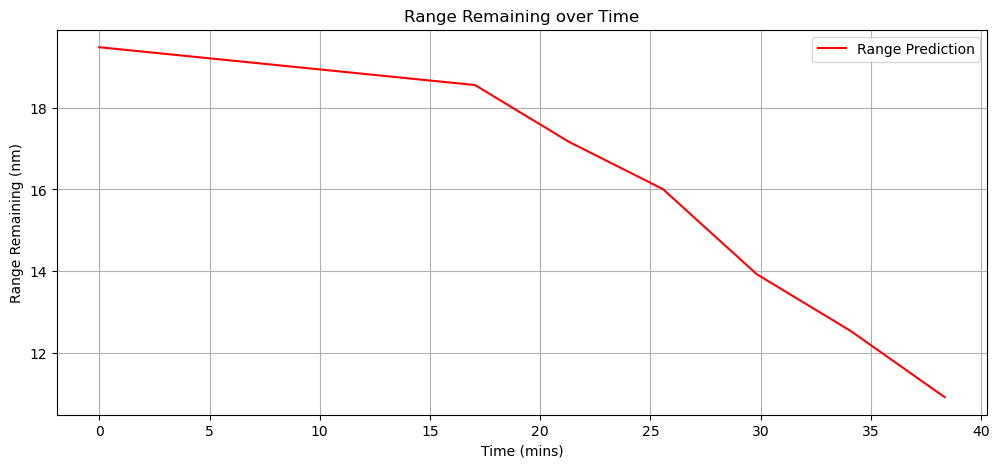

In [79]:
duration = (df['Time'].iloc[-1] - df['Time'].iloc[0]).seconds/60
x = np.linspace(0, duration, len(range_list))
y = range_list

x_smooth = np.linspace(np.min(x),np.max(x),num = 10) #Num represents number of points, play around to affect smoothness
bspline = interpolate.make_interp_spline(x,y)
y_smooth = bspline(x_smooth)

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(x_smooth, y_smooth, color='red')
ax1.set_title('Range Remaining over Time')
ax1.set_xlabel('Time (mins)')
ax1.set_ylabel('Range Remaining (nm)')
ax1.legend(['Range Prediction'])
ax1.grid()

# ax2 = ax1.twinx()
# ax2.plot(x, df['tripDistance'], color='green')
# ax2.set_ylabel('Distance Traveled (nm)')
# ax2.legend(['Distance Traveled'], loc='upper center')
# ax2.invert_yaxis()


### Accuracy

In [ ]:
# df['Dist Prediction (nm)'] = range_list
# N = range(300, len(df), 300)
# error_list = []
# for n in N:
#     pred = df['Dist Prediction (nm)'].iloc[n] - df['Dist Prediction (nm)'].iloc[-1]     # predicted distance remaining at n minus prediction at the end
#     dist = df['tripDistance'].iloc[-1] - df['tripDistance'].iloc[n]                       # actual distance traveled since n
#     error = abs(pred - dist)
#     error_list.append(error)
#     # print(n, 'Predicted:', round(pred, 2), '| Actual:', round(dist, 2), '| Error^2', round(error, 2))
# run_error = (sum(error_list)/len(error_list))
# df[['tripDistance', 'Dist Prediction (nm)']]

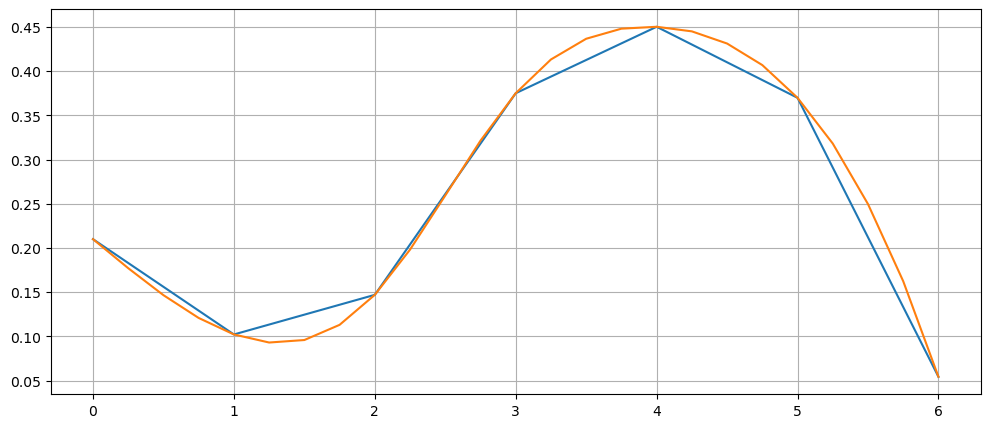

In [ ]:
run_error, errors = testing().test_accuracy(df, range_list, interval=300)

x = range(len(errors))
y = errors

x_smooth = np.linspace(np.min(x),np.max(x),num = 25) #Num represents number of points, play around to affect smoothness
bspline = interpolate.make_interp_spline(x,y)
y_smooth = bspline(x_smooth)

plt.figure(figsize=(12,5))
plt.plot(x, y, x_smooth, y_smooth)
plt.grid()

### Method Comparison Simulation

In [ ]:
# # Values to be stored in inifile
# batt_cap = 58
# stored_dist_avg = 2.5
# stored_time_avg = 0.3
# n_runs = 0
# roll_energy = 0
# roll_distance = 0

# # Class instances
# test_inst = testing()
# range_est = range_est(batt_cap,
#                       stored_dist_avg,
#                       stored_time_avg,
#                       n_runs,
#                       roll_energy,
#                       roll_distance)

# # lists to store accuracy of each run by different methods
# accuracies1 = []
# accuracies2 = []
# accuracies3 = []

# # Loop through runs
# for run in runs_dict.keys():
#     df = test_inst.add_variables(runs_dict[run])

#     # lists to store range values
#     range_dist_list = []
#     range_time_list = []
#     range_roll_list = []

#     # Loop through rows of current run data
#     for i in range(len(df)):
#         # Simulate dataStream
#         data = test_inst.parse_csv(df.iloc[i])

#         # Record range remaining for each method
#         range_est.overall_avg(data)
#         range_dist_list.append(range_est.range_remaining)

#         range_est.overall_time_avg(data)
#         range_time_list.append(range_est.range_remaining)

#         range_est.rolling_avg(data)
#         range_roll_list.append(range_est.range_remaining)

#     # Update averages once run is complete
#     range_est.update_avg(data)

#     # Check and record accuracy
#     error_dist, errors_dist = test_inst.test_accuracy(df, range_dist_list)
#     error_time, errors_time = test_inst.test_accuracy(df, range_time_list)
#     error_roll, errors_roll = test_inst.test_accuracy(df, range_roll_list)

#     accuracies1.append(error_dist)
#     accuracies2.append(error_time)
#     accuracies3.append(error_roll)

#     print(run, 'Error', error_dist, error_time, error_roll, end=' \r')

# # Create dataframe to store error values of each method for each run
# error_summary = pd.DataFrame({
#     'Run': runs_dict.keys(),
#     'Overall Distance Average': accuracies1,
#     'Overall Time Average': accuracies2,
#     'Rolling Average': accuracies3
# })


In [ ]:
error_summary

NameError: name 'error_summary' is not defined

### Plot Errors


 Distance Avg Error:     1.209790483453032 
 Time Avg Error:         1.7708435385904266 
 Rolling Avg Error:      3.177862116051092


Text(0, 0.5, 'Error (nm)')

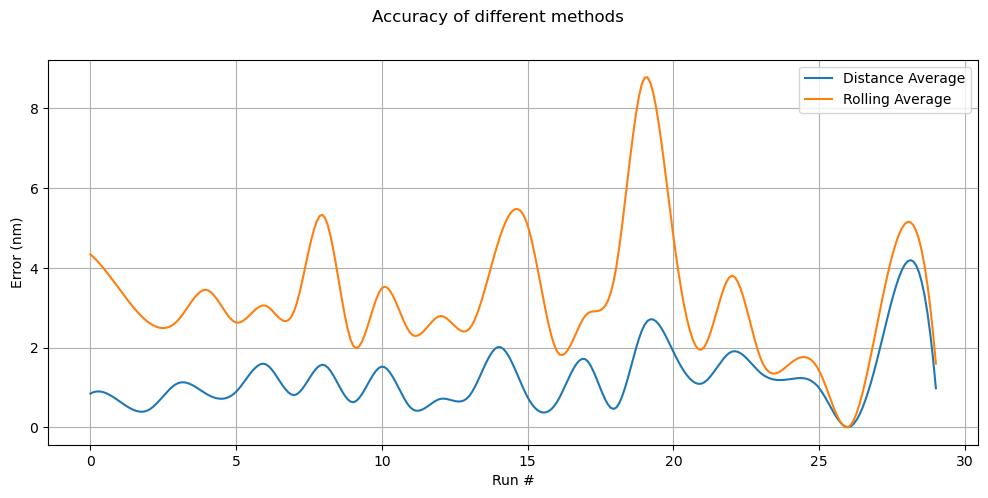

In [ ]:
print('\n', 
      'Distance Avg Error:    ', error_summary['Overall Distance Average'].mean(), '\n', 
      'Time Avg Error:        ', error_summary['Overall Time Average'].mean(), '\n',
      'Rolling Avg Error:     ', error_summary['Rolling Average'].mean())

x = error_summary.index
y1 = error_summary['Overall Distance Average']
# y2 = error_summary['Overall Time Average']
y3 = error_summary['Rolling Average']

num = len(error_summary)*10
x_smooth = np.linspace(np.min(x), np.max(x), num)
bspline1 = interpolate.make_interp_spline(x, y1)
# bspline2 = interpolate.make_interp_spline(x, y2)
bspline3 = interpolate.make_interp_spline(x, y3)
y1_smooth = bspline1(x_smooth)
# y2_smooth = bspline2(x_smooth)
y3_smooth = bspline3(x_smooth)

plt.figure(figsize=(12,5))
plt.plot(x_smooth, y1_smooth,
      #    x_smooth, y2_smooth,
         x_smooth, y3_smooth
         )
plt.grid()
# plt.legend(error_summary.columns[1:], loc='upper right')
plt.legend(['Distance Average', 'Rolling Average'], loc='upper right')
plt.suptitle('Accuracy of different methods')
plt.xlabel('Run #')
plt.ylabel('Error (nm)')

## Extra

In [ ]:
# '''Summary Plots'''
# plt.figure(figsize=(12,5))

# plt.subplot(2,2,1)
# plt.plot(df.index, df['SOC 1 %'])
# plt.grid()
# plt.title('Charge (%) over Time')

# plt.subplot(2,2,2)
# plt.plot(df.index, df['Speed m/s']) #, df['Power 1 kW'])
# plt.grid()
# plt.title('Power (kW) and Speed (kts) over Time')

# plt.subplot(2,2,3)
# plt.plot(df.index, df['Pack Voltage 1 V'], df['Pack Current 1 A'])
# plt.grid()
# plt.title('Current and Voltage over Time')

# # plt.subplot(2,2,4)
# # plt.plot(df.index)
# # plt.grid()
# # plt.title('Empty')

# plt.subplots_adjust(hspace = 0.5)
# plt.subplots_adjust(wspace = 0.3)

# df.head()

In [ ]:
# def rolling_avg1(self, data, nMins, roll_energy, roll_distance):
#     # Elliot's version
#     """This function evaluates range remaining on the battery where 
#     every nMins, roll_energy and roll_distance are updated accordingly to 
#     calculate the rolling average consumption rate. A logarithmic scale is 
#     applied to adjust value of the rolling average overtime. 
#     """
#     if data['tripDuration'] % nMins:
#         curr_roll_energy = data['energyUsed'] - roll_energy
#         curr_roll_distance = data['tripDistance'] - roll_distance
    
#     roll_consumption = curr_roll_energy/curr_roll_distance
#     curr_consumption = data['energyUsed']/data['tripDistance']
    
#     """Might need to fix but idea is that weight to curr consumption
#     only applies when log(10) < 1, otherwise it would be subtracting 
#     a negative consumption rate which is incorrect (1-(n>=1)). 
#     """
#     weight = math.log(self.data['tripDuration'])
#     if weight < 1:  
#         roll_avg = weight * roll_consumption + (1-weight) * curr_consumption  
#     roll_avg = weight * roll_consumption                                      

#     range_remaining = int(data['energyAvailable']/roll_avg)
#     return range_remaining, curr_roll_energy, curr_roll_distance